# Create a general MODFLOW model from the NHDPlus dataset

In [1]:
__author__ = 'Jeff Starn'
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import pandas as pd
import random
import gdal
from model_specs import *
from gen_mod_dict import *

from ipywidgets import interact, Dropdown
from IPython.display import display

In [2]:
for key, value in model_dict.items():
    md = key
    ms = model_dict[md]
    print('trying {}'.format(md))
    try:
        pass
    except:
        pass

trying Assabet
trying CoastalCT
trying CoastalCT250
trying Niantic
trying Niantic250
trying Niantic500
trying CoastalCT500


Project specific variables are imported in the model_spec.py and gen_mod_dict.py files that must be included in the notebook directory. The first first includes pathnames to data sources that will be different for each user. The second file includes a dictionary of model-specific information such as  cell size, default hydraulic parameter values, and scenario defintion (e.g. include bedrock, number of layers, etc.). There are examples in the repository. Run the following cell to get a pull-down menu of models in the model_dict. Then, without re-running that cell, run all the remaining cells.  Re-running the following cell would re-set the model to the first one in the list, which you probably don't want. If you use the notebook option to run all cells below, it runs the cell you're in, so if you use that option, move to the next cell (below the pull-down menu of models) first.

In [3]:
models = list(model_dict.keys())
models.sort()
model_area = Dropdown(
    options=models,
    description='Model:',
    background_color='cyan',
    border_color='black',
    border_width=2)
display(model_area)

In [4]:
md = model_area.value
ms = model_dict[md]
print('The model being processed is {}'.format(md))

The model being processed is Niantic250


Read model_grid.csv file that was created using first general model notebook

In [5]:
model_ws = os.path.join(proj_dir, ms['ws'])
model_file = os.path.join(model_ws, 'model_grid.csv')
model_grid = pd.read_csv(model_file, na_values=[hnoflo])
if 'obs_grp' in model_grid.columns:
    model_grid.drop('obs_grp', axis=1, inplace=True)

Get NROW, NCOL from model_grid.csv

In [6]:
NROW = model_grid.row.max() + 1
NCOL = model_grid.col.max() + 1
num_cells = NROW * NCOL

This cell makes a new column that contains the percent coarse material (which comes from 'is_coarse' in model_grid.csv') in the local neighborhood of each cell. The user can change the size of the neighborhood, which is a square blcok of cells centered on each cell as it moves, by changing the variable hood_size.

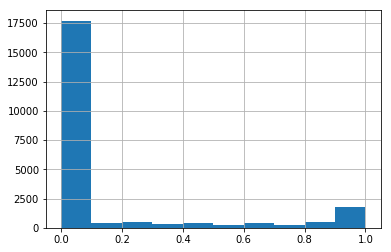

In [7]:
is_coarse = np.zeros(( NROW, NCOL ), dtype=np.float32)

gess = model_grid.gess_poly.values.reshape( NROW, NCOL )

is_coarse[gess == 0] = 0
is_coarse[gess == 1] = 1

# use this number to get broader dist of pct_coarse
# this might allow quantiles where otherwise none are possible
# this variable is not stored for the next step--only used here for quantiles
hood_size = 5
footprint = np.ones((hood_size, hood_size)) / hood_size**2
temp = nd.correlate(is_coarse, footprint,)
model_grid['pct_coarse'] = temp.ravel()
model_grid.pct_coarse.hist()

* Select 'hydro' obs from model_grid
* Put the integer that represents unique reaches into the index
* Groupby the reach integer so that all the cells that belong to a reach are grouped together
* Add labels to identify the quantiles of the median elevation of all the cells for each reach
* Groupby by those quantiles so that all the cells that belong to each quantile are grouped together
* Loop through the rows from the original dataframe and select the rows that belong to the elevation quantile group
* Label each group as they're being looped through and append them for each observation
* The commented-out statement could be used to randomly sample from each group


In [8]:
# make additional obs using drain observation in MODFLOW (should be > 0)
# pull out drain flows from budget package for first order
# also summarize flow at gages
sel = pd.DataFrame(model_grid[model_grid.obs_type == 'hydro'])
sel.set_index(sel.reach_int, drop=False, inplace=True)

num_of_samples = 10
num_of_obs = 5

o1 = sel.groupby(['reach_int']).median()
o1['top_quant'], rbins = pd.qcut(o1.top, num_of_obs, retbins=True, labels=False)

temp = o1.groupby(['top_quant'])
stream_obs = pd.DataFrame()
for grp, item in temp:
    obs = pd.DataFrame(sel.loc[item.index])
    obs['obs_grp'] = 'strm_el{}'.format(grp)
    obs['obs_grp_int'] = grp + 1
    stream_obs = pd.concat([stream_obs, obs])

In [9]:
# note: possible enhancement is to add within-cell percent coarse
num_of_obs = 3

is_topo = model_grid.obs_type == 'topo'

try:
    model_grid.loc[is_topo, 'top_quant'] = pd.qcut(model_grid.top, num_of_obs, labels=[1, 2, 3])
except: pass

try:
    model_grid.loc[is_topo, 'coarse_grp'] = pd.cut(model_grid.pct_coarse, [0.0, 0.1, 0.9, 1.0], 
                                         include_lowest=True, labels=[1, 2, 3])
except:
    pass

try:
    mini_mohp = model_grid.dist2str / model_grid.dist2str.max()
    model_grid.loc[is_topo, 'hypo_quant'] = pd.cut(mini_mohp, [0.0, 0.3333, 0.6666, 1.0], 
                                                   include_lowest=True, labels=[1, 2, 3])
except:
    pass

Each cell saves one of the individual quantiles or quantile-based observation groups as tiff files

In [10]:
data = model_grid.pct_coarse.values.reshape(NROW,NCOL)

src_pth = os.path.join(model_ws, 'ibound.tif')
src = gdal.Open(src_pth)

dst_pth = os.path.join(model_ws, 'pct_coarse.tif')
driver = gdal.GetDriverByName('GTiff')
dst = driver.CreateCopy(dst_pth, src, 0)

band = dst.GetRasterBand(1)
band.WriteArray(data)
band.SetNoDataValue(-9999)

dst = None
src = None

In [11]:
data = model_grid.coarse_grp.values.reshape(NROW,NCOL)

src_pth = os.path.join(model_ws, 'ibound.tif')
src = gdal.Open(src_pth)

dst_pth = os.path.join(model_ws, 'coarse_grp.tif')
driver = gdal.GetDriverByName('GTiff')
dst = driver.CreateCopy(dst_pth, src, 0)

band = dst.GetRasterBand(1)
band.WriteArray(data)
band.SetNoDataValue(255)

dst = None
src = None

In [12]:
data = model_grid.hypo_quant.values.reshape(NROW,NCOL)

src_pth = os.path.join(model_ws, 'ibound.tif')
src = gdal.Open(src_pth)

dst_pth = os.path.join(model_ws, 'hypo_quant.tif')
driver = gdal.GetDriverByName('GTiff')
dst = driver.CreateCopy(dst_pth, src, 0)

band = dst.GetRasterBand(1)
band.WriteArray(data)
band.SetNoDataValue(255)

dst = None
src = None

In [13]:
data = model_grid.top_quant.values.reshape(NROW,NCOL)

src_pth = os.path.join(model_ws, 'ibound.tif')
src = gdal.Open(src_pth)

dst_pth = os.path.join(model_ws, 'top_quant.tif')
driver = gdal.GetDriverByName('GTiff')
dst = driver.CreateCopy(dst_pth, src, 0)

band = dst.GetRasterBand(1)
band.WriteArray(data)
band.SetNoDataValue(255)

dst = None
src = None

In [14]:
blank = np.zeros((num_cells))
blank[stream_obs.node_num.values] = stream_obs.obs_grp_int
data = blank.reshape((NROW,NCOL))

src_pth = os.path.join(model_ws, 'ibound.tif')
src = gdal.Open(src_pth)

dst_pth = os.path.join(model_ws, 'stream_obs.tif')
driver = gdal.GetDriverByName('GTiff')
dst = driver.CreateCopy(dst_pth, src, 0)

band = dst.GetRasterBand(1)
band.WriteArray(data)
band.SetNoDataValue(0)

dst = None
src = None